<a href="https://colab.research.google.com/github/3catz/finance/blob/master/corrections_LGBM_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beginnings

In [1]:
!pip install pyentrp
# !pip install nolds
!pip install git+https://github.com/manu-mannattil/nolitsa.git
!pip install saxpy
!pip install requests_html
!pip install fix_yahoo_finance --upgrade --no-cache-dir


  Stored in directory: /root/.cache/pip/wheels/03/d8/63/f9589ba183381c68af5a57794b1efb6dff66825fa6ce858c19
Successfully built pyentrp
  Cloning https://github.com/manu-mannattil/nolitsa.git to /tmp/pip-req-build-5ump3uel
  Running command git clone -q https://github.com/manu-mannattil/nolitsa.git /tmp/pip-req-build-5ump3uel
  Stored in directory: /tmp/pip-ephem-wheel-cache-6f2fyt92/wheels/9b/2e/49/14f1c7a1b4acd6716bb946b6b40d722c4be76fd0e5b1ade611
Successfully built nolitsa
     |████████████████████████████████| 184kB 3.5MB/s 
     |████████████████████████████████| 215kB 51.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/68/d1/a0/a2a4f96eb82607654bc45f00479af34ddd7c45be9096b8e63c
Successfully built saxpy
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.

In [2]:
import os 
from google.colab import auth
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import StandardScaler
from pandas import read_csv
from keras.models import Sequential

from glob import glob

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score

import matplotlib.pyplot as plt


from collections import Counter 

import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import confusion_matrix, recall_score, classification_report, f1_score, roc_auc_score, recall_score
from sklearn.model_selection import train_test_split
#from pyts.classification import *
from pyentrp import entropy as ent 
from imblearn.ensemble import BalanceCascade
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score


Using TensorFlow backend.


In [0]:
import os 
os.listdir()

['.config', 'adc.json', 'data_stocks.csv', 'sample_data']

In [0]:
def data_creator(ticker):
  import fix_yahoo_finance as yf 
  from saxpy.znorm import znorm
  hist = yf.download(tickers = ticker, period = 'max')
  hist = hist["Close"]
  pc = [(hist[i + 1] - hist[i])/hist[i] for i in range(len(hist) -1)]
  pc2 = znorm(pc)
  pc3 = [np.floor(c) for c in pc2]
  X = ent.util_pattern_space(pc2, lag = 1, dim = 21)
  X.shape
  trainY = X[:,-1]
  trainX = X[:,:-1]
  trainY = np.where(trainY <= -4, True, False)
  drops = np.where(trainY == True)
  return trainX, trainY, drops

In [316]:
tick_list = ["VTI","VOO","VEA","VWO","VTV","VUG",
             "VO","VB","VEU","VIG","VHT","VFH","VPL",
             "VPU","VSS","VGK","VOT","VSS","VAS","VGT",
             "EFA","EWA","EWH","EWG","EWU","EWQ","EWL","EWP",
             "EWD","EWN","EWI","ERUS","UAE","EIS","INDA"]
             
x_stack = []
y_stack = []
for tick in tick_list:
  x, y, bob = data_creator(tick)
  x_stack.append(x)
  y_stack.append(y)

X = np.vstack(x_stack)
Y = np.hstack(y_stack)
print(X.shape, Y.shape)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*******************

In [317]:
import fix_yahoo_finance as yf 
hist = yf.download(tickers = ticker, period = 'max')
hist = hist["Close"]
pc = [(hist[i + 1] - hist[i])/hist[i] for i in range(len(hist) -1)]
print(np.mean(pc), np.std(pc), np.mean(pc) - 4*np.std(pc))

[*********************100%***********************]  1 of 1 downloaded
0.00022008157773891572 0.01359577568898762 -0.05416302117821156


# Raw, Unbalanced Data 


In [0]:
trainX, testX, trainY, testY = train_test_split(X,Y, shuffle = True)

In [274]:
print(trainX.shape, testX.shape)
import collections
print(collections.Counter(trainY), collections.Counter(testY))

(95731, 20) (31911, 20)
Counter({False: 95388, True: 343}) Counter({False: 31796, True: 115})


# using SMOTE to create balanced data set

In [318]:
from imblearn.over_sampling import SMOTE
mask = np.all(np.isnan(X), axis=1) 
X = X[~mask]
Y = Y[~mask]
sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X, Y)
print(X_res.shape, Y_res.shape)
trainX, testX, trainY, testY = train_test_split(X_res,Y_res, shuffle = True)
print(collections.Counter(trainY), collections.Counter(testY))

(271086, 20) (271086,)
Counter({True: 101764, False: 101550}) Counter({False: 33993, True: 33779})


# HP tuning

In [319]:
param_test ={
             'num_leaves': sp_randint(30, 200), 
             'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.5, scale=0.5),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'bagging_fraction': sp_uniform(loc=0.5,scale=0.5),
             'feature_fraction':sp_uniform(loc=0.5, scale = 0.5)}



fit_params={"early_stopping_rounds": 30, 
            
            "eval_metric" : ['binary_error'], 
            "eval_set" : [(testX, testY)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

n_HP_points_to_test = 5



#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state = 333, silent=False, 
                         metric = None, n_jobs=4, class_weight='balanced',
                         # np.random.randint(50), 0: 1},
                         n_estimators = 4000, objective = 'binary', is_unbalanced = True)
gs = RandomizedSearchCV(
     estimator = clf, param_distributions=param_test, 
     n_iter = n_HP_points_to_test,
     scoring = ['balanced_accuracy','f1_weighted'],
     cv = 3,
     refit = 'balanced_accuracy',
     random_state = 320,
     verbose = True)



gs.fit(trainX, trainY, **fit_params)

print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_error: 0.0772443
Early stopping, best iteration is:
[75]	valid's binary_error: 0.0748982
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[4]	valid's binary_error: 0.0814201
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[9]	valid's binary_error: 0.0760344
Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_error: 0.0397952
[200]	valid's binary_error: 0.0295697
[300]	valid's binary_error: 0.0210706
[400]	valid's binary_error: 0.0147554
[500]	valid's binary_error: 0.010196
[600]	valid's binary_error: 0.00693502
[700]	valid's binary_error: 0.00503158
[800]	valid's binary_error: 0.00414626
[900]	valid's binary_error: 0.00360031
[1000]	valid's binary_error: 0.00314289
[1100]	valid's binary_error: 0.00272974
[1200]	valid's binary_error: 0.00249366
Early stopping, best iteration is:


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  9.2min finished


Training until validation scores don't improve for 30 rounds.
[100]	valid's binary_error: 0.0369179
[200]	valid's binary_error: 0.0265449
[300]	valid's binary_error: 0.018695
[400]	valid's binary_error: 0.0127634
[500]	valid's binary_error: 0.00817447
[600]	valid's binary_error: 0.00569557
[700]	valid's binary_error: 0.0042643
[800]	valid's binary_error: 0.003438
[900]	valid's binary_error: 0.00289205
[1000]	valid's binary_error: 0.0024789
[1100]	valid's binary_error: 0.0022133
[1200]	valid's binary_error: 0.00205099
Early stopping, best iteration is:
[1171]	valid's binary_error: 0.00205099
Best score reached: 0.9977652808312624 with params: {'bagging_fraction': 0.8038446632925362, 'colsample_bytree': 0.5257451638948233, 'feature_fraction': 0.5665902906167368, 'learning_rate': 0.01, 'min_child_samples': 376, 'min_child_weight': 0.001, 'num_leaves': 74, 'reg_alpha': 7, 'reg_lambda': 0, 'subsample': 0.8420944718653172} 


In [320]:
bst = gs.best_estimator_
#print(bst.get_params)
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 

print(roc_auc_score(testY, bst.predict(testX), average = 'weighted'))
print(classification_report(testY, bst.predict(testX), target_names = ["Zero", "One"]))
cm = confusion_matrix(testY, np.round(bst.predict(testX)), labels=[0,1])
print(cm)



0.9979546227506589
              precision    recall  f1-score   support

        Zero       1.00      1.00      1.00     33993
         One       1.00      1.00      1.00     33779

   micro avg       1.00      1.00      1.00     67772
   macro avg       1.00      1.00      1.00     67772
weighted avg       1.00      1.00      1.00     67772

[[33863   130]
 [    9 33770]]


In [0]:
bst.get_params

# Calibrating the Classifier 

In [321]:
from sklearn.calibration import CalibratedClassifierCV
calib = CalibratedClassifierCV(base_estimator = bst, cv = 3)
calib.fit(trainX,trainY)

print(roc_auc_score(testY, calib.predict(testX), average = 'weighted'))
print(classification_report(testY, calib.predict(testX), target_names = ["Zero", "One"]))
cm = confusion_matrix(testY, np.round(calib.predict(testX)), labels=[0,1])
print(cm)



0.9986606504622466
              precision    recall  f1-score   support

        Zero       1.00      1.00      1.00     33993
         One       1.00      1.00      1.00     33779

   micro avg       1.00      1.00      1.00     67772
   macro avg       1.00      1.00      1.00     67772
weighted avg       1.00      1.00      1.00     67772

[[33911    82]
 [    9 33770]]


# Testing on unseen data 

In [291]:
collections.Counter(trainY)

Counter({False: 95388, True: 343})

models


In [340]:
from imblearn.metrics import classification_report_imbalanced as cimb


def reporter(clf, ticker, recall):
  x, y, b = data_creator(ticker)
  preds = clf.predict_proba(x[b])
  t = np.quantile(preds[:,-1], (1-recall))
  pclass= []
  all_preds = clf.predict_proba(x)
  for i in range(len(x)):
    if all_preds[i,-1] >= t:
      pclass.append(True)
    else:
      pclass.append(False)
  print(roc_auc_score(y,pclass))
  print(classification_report(y,pclass))
  print(confusion_matrix(y, pclass))
      
tick = "VT"
recall = 0.5
reporter(clf = calib, ticker = tick, recall = recall)
reporter(clf = bst, ticker = tick, recall = recall)

[*********************100%***********************]  1 of 1 downloaded
0.7692307692307692
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2699
        True       1.00      0.54      0.70        13

   micro avg       1.00      1.00      1.00      2712
   macro avg       1.00      0.77      0.85      2712
weighted avg       1.00      1.00      1.00      2712

[[2699    0]
 [   6    7]]
[*********************100%***********************]  1 of 1 downloaded
0.7692307692307692
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2699
        True       1.00      0.54      0.70        13

   micro avg       1.00      1.00      1.00      2712
   macro avg       1.00      0.77      0.85      2712
weighted avg       1.00      1.00      1.00      2712

[[2699    0]
 [   6    7]]


[*********************100%***********************]  1 of 1 downloaded


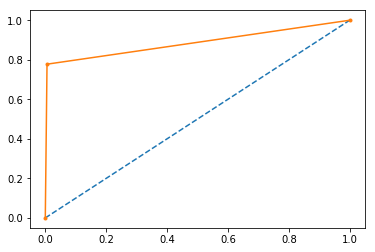

[*********************100%***********************]  1 of 1 downloaded


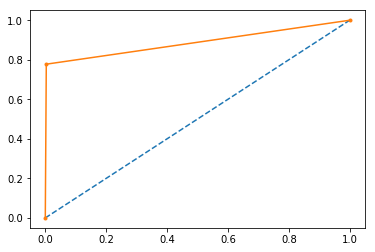

In [323]:
from sklearn.metrics import roc_curve
def roc_plotter(clf, ticker):
  x, y, b = data_creator(ticker)
  fpr, tpr, thresholds = roc_curve(y, clf.predict(x))
# plot no skill
  plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
  plt.plot(fpr, tpr, marker='.')
# show the plot
  plt.show()
  
roc_plotter(bst, "IOO")
roc_plotter(calib, "IOO")

80.878 --> 69.946 --> 69.340 --> 69.136 --> 69.015 --> 68.942 --> 68.942 --> 


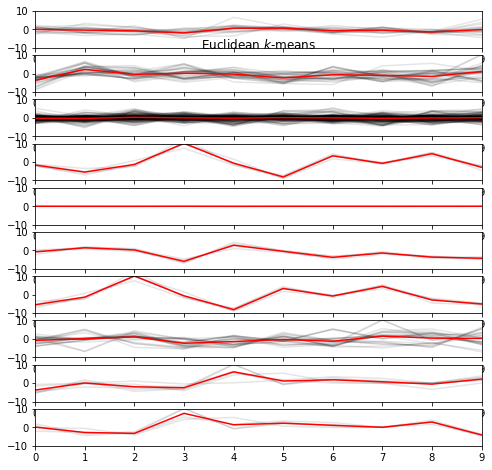

In [0]:
!pip install tslearn
n = 10
from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters = n,verbose=True)
y_pred = km.fit_predict(bads)

#collections.Counter(y_pred)

fig = plt.figure(figsize=(8,8))
for yi in range(n):
    ax = plt.subplot(n, 1, yi + 1)
    for xx in bads[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.10)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 9)
    plt.ylim(-10, 10)
    if yi == 1:
        plt.title("Euclidean $k$-means")
fig.savefig('dowjones_clusters.png')